In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import tensorflow as tf

In [3]:
import sys, os
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [4]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train /255.0 * 2-1, x_test / 255.0 * 2 -1

x_train.shape

(60000, 28, 28)

In [5]:
N, H, W = x_train.shape
D = H*W
x_train = x_train.reshape(-1,D)
x_test= x_test.reshape(-1,D)

In [6]:
latent_dim = 100

In [13]:
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation = LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512, activation = LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024, activation = LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(D, activation = 'tanh')(x)
    
    model = Model(i,x)
    return model


In [14]:
def build_discriminator(img_size):
    i = Input(shape=(img_size,))
    x = Dense(512, activation = LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation = LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation = 'sigmoid')(x)
    model = Model(i,x)
    return model

In [15]:
discriminator = build_discriminator(D)
discriminator.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(0.0002,0.5),
    metrics = ['accuracy']
)
#build and compile combined model
generator = build_generator(latent_dim)
#create input noise sample
z = Input(shape=(latent_dim,))
#pass noise to generator
img = generator(z)
#only train generator
discriminator.trainable = False
#label output as real
fake_pred = discriminator(img)
#create combined model object
combined_model = Model(z, fake_pred)
#compile combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))


In [16]:
#Train GAN

batch_size = 32
epochs = 30000
sample_period = 200

#create batch labels to use when calling train on batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

d_losses = []
g_losses = []
#create a folder for generated images
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

In [17]:
#a function to generate a grid of random samples from the generator

def sample_images(epochs):
    rows, cols = 5,5
    noise = np.random.randn(rows*cols,latent_dim)
    imgs = generator.predict(noise)
    #Rescale images 0-1
    imgs = 0.5*imgs + 0.5
    fig, axs = plt.subplots(rows,cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(H,W),cmap='gray')
            axs[i,j].axis('off')
            idx +=1
    fig.savefig('gan_images/%d.png' % epoch)
    plt.close()
    

In [18]:
#Main training loop
for epoch in range(epochs):
    #
    ### Train Discriminator ###
    #
    #Select random batch on images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]
    
    #Generate fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)
    
    #Train the discriminator return both loss and accuracy
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)
    #
    ### Train Generator ###
    #
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise,ones)
    
    #save the losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch % 100 == 0:
        print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f},\
        d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
        
    if epoch % sample_period == 0:
        sample_images(epoch)
    
    

epoch: 1/30000, d_loss: 0.61,        d_acc: 0.52, g_loss: 0.53
epoch: 101/30000, d_loss: 0.01,        d_acc: 1.00, g_loss: 4.74
epoch: 201/30000, d_loss: 0.03,        d_acc: 1.00, g_loss: 5.45
epoch: 301/30000, d_loss: 0.20,        d_acc: 0.95, g_loss: 3.63
epoch: 401/30000, d_loss: 0.41,        d_acc: 0.83, g_loss: 2.82
epoch: 501/30000, d_loss: 0.71,        d_acc: 0.41, g_loss: 0.70
epoch: 601/30000, d_loss: 0.69,        d_acc: 0.41, g_loss: 0.70
epoch: 701/30000, d_loss: 0.64,        d_acc: 0.62, g_loss: 0.76
epoch: 801/30000, d_loss: 0.66,        d_acc: 0.61, g_loss: 0.73
epoch: 901/30000, d_loss: 0.66,        d_acc: 0.58, g_loss: 0.74
epoch: 1001/30000, d_loss: 0.64,        d_acc: 0.62, g_loss: 0.82
epoch: 1101/30000, d_loss: 0.62,        d_acc: 0.67, g_loss: 0.83
epoch: 1201/30000, d_loss: 0.60,        d_acc: 0.67, g_loss: 0.85
epoch: 1301/30000, d_loss: 0.64,        d_acc: 0.72, g_loss: 0.88
epoch: 1401/30000, d_loss: 0.67,        d_acc: 0.58, g_loss: 0.81
epoch: 1501/30000, d_l

epoch: 12401/30000, d_loss: 0.61,        d_acc: 0.72, g_loss: 0.96
epoch: 12501/30000, d_loss: 0.67,        d_acc: 0.58, g_loss: 0.95
epoch: 12601/30000, d_loss: 0.64,        d_acc: 0.69, g_loss: 1.03
epoch: 12701/30000, d_loss: 0.62,        d_acc: 0.62, g_loss: 1.05
epoch: 12801/30000, d_loss: 0.62,        d_acc: 0.62, g_loss: 0.99
epoch: 12901/30000, d_loss: 0.59,        d_acc: 0.67, g_loss: 0.91
epoch: 13001/30000, d_loss: 0.65,        d_acc: 0.67, g_loss: 0.81
epoch: 13101/30000, d_loss: 0.57,        d_acc: 0.73, g_loss: 1.05
epoch: 13201/30000, d_loss: 0.62,        d_acc: 0.67, g_loss: 1.01
epoch: 13301/30000, d_loss: 0.64,        d_acc: 0.61, g_loss: 0.97
epoch: 13401/30000, d_loss: 0.61,        d_acc: 0.67, g_loss: 0.98
epoch: 13501/30000, d_loss: 0.62,        d_acc: 0.67, g_loss: 1.07
epoch: 13601/30000, d_loss: 0.57,        d_acc: 0.72, g_loss: 1.04
epoch: 13701/30000, d_loss: 0.64,        d_acc: 0.67, g_loss: 1.02
epoch: 13801/30000, d_loss: 0.62,        d_acc: 0.73, g_loss: 

epoch: 24701/30000, d_loss: 0.67,        d_acc: 0.55, g_loss: 1.04
epoch: 24801/30000, d_loss: 0.66,        d_acc: 0.61, g_loss: 0.94
epoch: 24901/30000, d_loss: 0.59,        d_acc: 0.62, g_loss: 0.98
epoch: 25001/30000, d_loss: 0.73,        d_acc: 0.50, g_loss: 0.97
epoch: 25101/30000, d_loss: 0.65,        d_acc: 0.61, g_loss: 0.97
epoch: 25201/30000, d_loss: 0.63,        d_acc: 0.66, g_loss: 1.03
epoch: 25301/30000, d_loss: 0.59,        d_acc: 0.66, g_loss: 0.94
epoch: 25401/30000, d_loss: 0.61,        d_acc: 0.67, g_loss: 1.10
epoch: 25501/30000, d_loss: 0.63,        d_acc: 0.61, g_loss: 1.09
epoch: 25601/30000, d_loss: 0.58,        d_acc: 0.70, g_loss: 0.97
epoch: 25701/30000, d_loss: 0.63,        d_acc: 0.64, g_loss: 1.07
epoch: 25801/30000, d_loss: 0.64,        d_acc: 0.58, g_loss: 1.10
epoch: 25901/30000, d_loss: 0.71,        d_acc: 0.62, g_loss: 1.12
epoch: 26001/30000, d_loss: 0.67,        d_acc: 0.59, g_loss: 1.11
epoch: 26101/30000, d_loss: 0.63,        d_acc: 0.66, g_loss: 

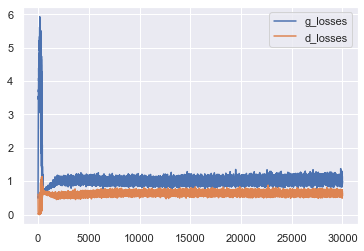

In [19]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label = 'd_losses')
plt.legend()

In [20]:
!ls gan_images

0.png
1000.png
10000.png
10200.png
10400.png
10600.png
10800.png
11000.png
11200.png
11400.png
11600.png
11800.png
1200.png
12000.png
12200.png
12400.png
12600.png
12800.png
13000.png
13200.png
13400.png
13600.png
13800.png
1400.png
14000.png
14200.png
14400.png
14600.png
14800.png
15000.png
15200.png
15400.png
15600.png
15800.png
1600.png
16000.png
16200.png
16400.png
16600.png
16800.png
17000.png
17200.png
17400.png
17600.png
17800.png
1800.png
18000.png
18200.png
18400.png
18600.png
18800.png
19000.png
19200.png
19400.png
19600.png
19800.png
200.png
2000.png
20000.png
20200.png
20400.png
20600.png
20800.png
21000.png
21200.png
21400.png
21600.png
21800.png
2200.png
22000.png
22200.png
22400.png
22600.png
22800.png
23000.png
23200.png
23400.png
23600.png
23800.png
2400.png
24000.png
24200.png
24400.png
24600.png
24800.png
25000.png
25200.png
25400.png
25600.png
25800.png
2600.png
26000.png
26200.png
26400.png
26600.png
26800.png
27000.png
27200.png
27400.png
27600.png
27800.png
2800.

In [23]:
!pip install scikit-image

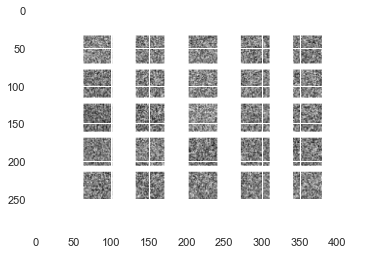

In [24]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

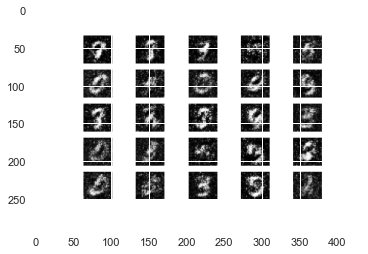

In [25]:
a = imread('gan_images/1000.png')
plt.imshow(a)

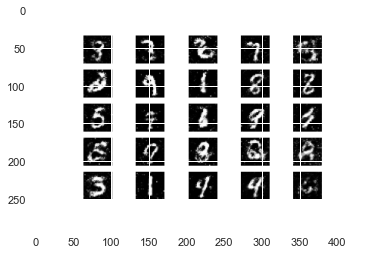

In [26]:
a = imread('gan_images/5000.png')
plt.imshow(a)

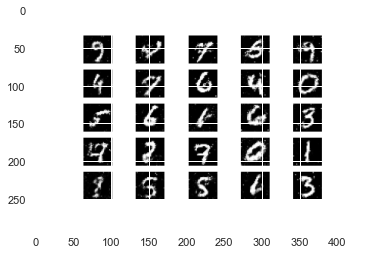

In [27]:
a = imread('gan_images/10000.png')
plt.imshow(a)

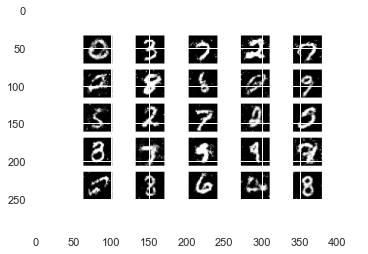

In [28]:
a = imread('gan_images/20000.png')
plt.imshow(a)

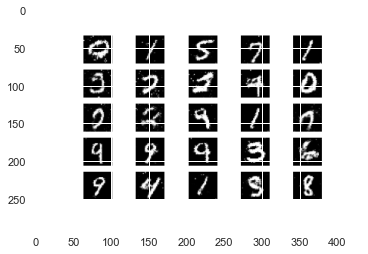

In [29]:
a = imread('gan_images/29000.png')
plt.imshow(a)